In [441]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [442]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.metrics import auc,roc_auc_score,roc_curve,precision_score,recall_score,f1_score
import time as timer
from sklearn.inspection import permutation_importance

In [443]:
# import package
# open dataset
df = "/content/gdrive/MyDrive/Dataset/healthcare-dataset-stroke-data.csv"
data = pd.read_csv(df)
with pd.option_context('expand_frame_repr', False):
    print(data.head())
print("Data shape: {}".format(data.shape))

      id  gender   age  hypertension  heart_disease ever_married      work_type Residence_type  avg_glucose_level   bmi   smoking_status  stroke
0   9046    Male  67.0             0              1          Yes        Private          Urban             228.69  36.6  formerly smoked       1
1  51676  Female  61.0             0              0          Yes  Self-employed          Rural             202.21   NaN     never smoked       1
2  31112    Male  80.0             0              1          Yes        Private          Rural             105.92  32.5     never smoked       1
3  60182  Female  49.0             0              0          Yes        Private          Urban             171.23  34.4           smokes       1
4   1665  Female  79.0             1              0          Yes  Self-employed          Rural             174.12  24.0     never smoked       1
Data shape: (5110, 12)


In [444]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [445]:
missing_val = data.isnull().sum()/len(data)*100
print(missing_val)
print("Missing values in variable bmi: {:.2f}%".format(missing_val['bmi']))
print("Missing values in variable smoking_status: {:.2f}%".format(missing_val['smoking_status']))
print("Data shape: {}".format(data.shape))


id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64
Missing values in variable bmi: 3.93%
Missing values in variable smoking_status: 0.00%
Data shape: (5110, 12)


In [446]:
# Safely disable new warning with the chained assignment.
pd.options.mode.chained_assignment = None  # default='warn'
# replace missing values in variable 'bmi' with its mean
data['bmi']=data['bmi'].fillna(data['bmi'].mean())
# remove (drop) data associated with missing values in variable 'smoking_status'
clean_data = data[data['smoking_status'].notnull()]
# drop variable 'id'
clean_data.drop(columns='id',axis=1,inplace=True)
# validate there's no more missing values
missing_val = clean_data.isnull().sum()/len(clean_data)*100
print(missing_val)
print("Missing values in variable 'bmi': {}".format(missing_val['bmi']))
print("Missing values in variable 'smoking_status': {}".format(missing_val['smoking_status']))
print("Shape of data without missing values: {}".format(clean_data.shape))

gender               0.0
age                  0.0
hypertension         0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
Residence_type       0.0
avg_glucose_level    0.0
bmi                  0.0
smoking_status       0.0
stroke               0.0
dtype: float64
Missing values in variable 'bmi': 0.0
Missing values in variable 'smoking_status': 0.0
Shape of data without missing values: (5110, 11)


In [447]:
# create encoder for each categorical variable
label_gender = LabelEncoder()
label_married = LabelEncoder()
label_work = LabelEncoder()
label_residence = LabelEncoder()
label_smoking = LabelEncoder()

In [448]:
clean_data['gender'] = label_gender.fit_transform(clean_data['gender'])
clean_data['ever_married'] = label_married.fit_transform(clean_data['ever_married'])
clean_data['work_type']= label_work.fit_transform(clean_data['work_type'])
clean_data['Residence_type']= label_residence.fit_transform(clean_data['Residence_type'])
clean_data['smoking_status']= label_smoking.fit_transform(clean_data['smoking_status'])
with pd.option_context('expand_frame_repr', False):
    print(clean_data.head())

   gender   age  hypertension  heart_disease  ever_married  work_type  Residence_type  avg_glucose_level        bmi  smoking_status  stroke
0       1  67.0             0              1             1          2               1             228.69  36.600000               1       1
1       0  61.0             0              0             1          3               0             202.21  28.893237               2       1
2       1  80.0             0              1             1          2               0             105.92  32.500000               2       1
3       0  49.0             0              0             1          2               1             171.23  34.400000               3       1
4       0  79.0             1              0             1          3               0             174.12  24.000000               2       1


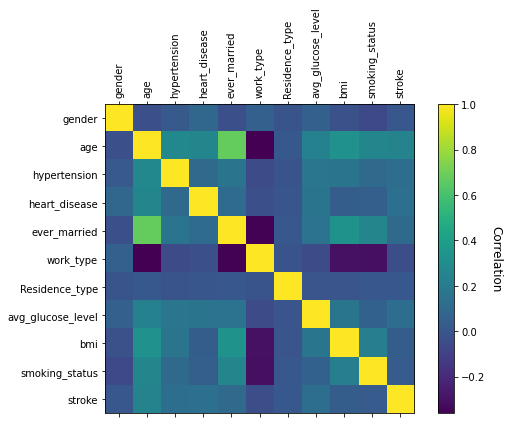

In [449]:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.matshow(clean_data.corr())
ax.set_xticks(np.arange(clean_data.shape[1]))
ax.set_yticks(np.arange(clean_data.shape[1]))
ax.set_xticklabels(clean_data.columns,rotation=90)
ax.set_yticklabels(clean_data.columns)
# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Correlation", rotation=-90, va="bottom", fontsize=12)
fig.tight_layout()
plt.show()

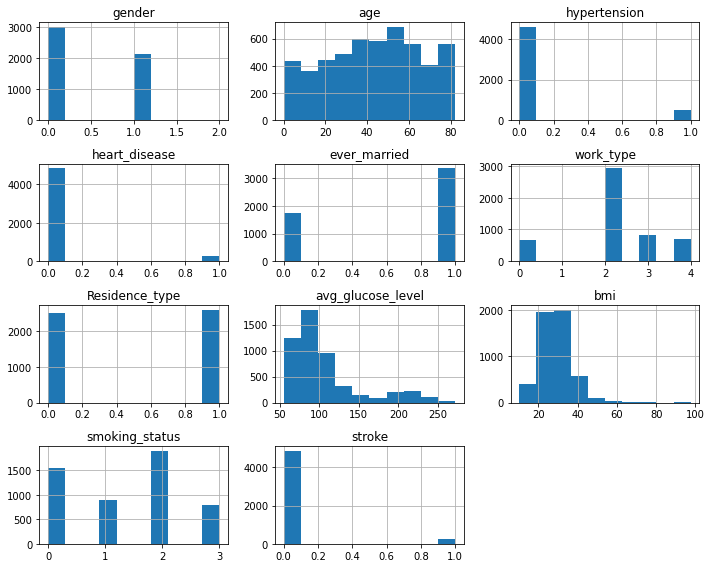

In [450]:
fig = clean_data.hist(figsize=(10,8))
plt.tight_layout()
plt.show()

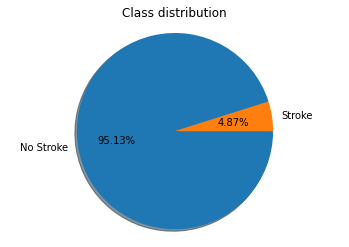

# samples associated with no stroke: 4861
# samples associated with stroke: 249


In [451]:
class_occur = clean_data['stroke'].value_counts()
class_names = ['No Stroke','Stroke']
fig, ax = plt.subplots()
ax.pie(class_occur, labels=class_names, autopct='%1.2f%%',
        shadow=True, startangle=0, counterclock=False)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Class distribution')
plt.show()
print("# samples associated with no stroke: {}".format(class_occur[0]))
print("# samples associated with stroke: {}".format(class_occur[1]))

In [452]:
from imblearn.over_sampling import SMOTE
# create the  object with the desired sampling strategy.
smote = SMOTE(sampling_strategy='minority')
oversample = SMOTE()
# fit the object to our training data
X, y = smote.fit_resample(clean_data.loc[:,clean_data.columns!='stroke'], clean_data['stroke'])
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

Shape of X: (9722, 10)
Shape of y: (9722,)


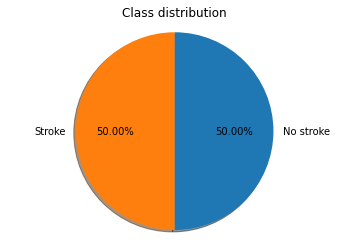

# samples associated with no stroke: 4861
# samples associated with stroke: 4861


In [453]:
_, class_counts = np.unique(y, return_counts=True)
class_names = ['No stroke', 'Stroke']
fig, ax = plt.subplots()
ax.pie(class_counts, labels=class_names, autopct='%1.2f%%',
        shadow=True, startangle=90, counterclock=False)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Class distribution')
plt.show()
print("# samples associated with no stroke: {}".format(class_counts[0]))
print("# samples associated with stroke: {}".format(class_counts[1]))

In [454]:
def split_train_valid_test(X,y,test_size=0.1,random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=random_state, stratify=y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=test_size/(1-test_size), random_state=random_state, stratify=y_train)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

X_train, X_valid, X_test, y_train, y_valid, y_test = split_train_valid_test(X,y,test_size=0.1,random_state=42)
_, train_counts = np.unique(y_train, return_counts=True)
_, valid_counts = np.unique(y_valid, return_counts=True)
_, test_counts = np.unique(y_test, return_counts=True)
print("[train] # class 0: {} | # class 1: {}".format(train_counts[0],train_counts[1]))
print("[valid] # class 0: {} | # class 1: {}".format(valid_counts[0],valid_counts[1]))
print("[test]  # class 0: {} | # class 1: {}".format(test_counts[0],test_counts[1]))

[train] # class 0: 3888 | # class 1: 3888
[valid] # class 0: 486 | # class 1: 487
[test]  # class 0: 487 | # class 1: 486


In [455]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_valid_std = scaler.transform(X_valid)
X_test_std = scaler.transform(X_test)

In [456]:
def calc_sens_spec(y_true,y_pred):
    conf_matrix = confusion_matrix(y_true,y_pred)
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    # calculate the sensitivity
    sensitivity = TP / (TP + FN)    
    # calculate the specificity
    specificity = TN / (TN + FP)
    return sensitivity,specificity

In [457]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_std, y_train)
# Predicting the test set results
y_knn = knn_model.predict(X_test_std)
y_knn_prob = knn_model.predict_proba(X_test_std)

Classification report for knn: 
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       487
           1       0.83      0.95      0.89       486

    accuracy                           0.88       973
   macro avg       0.89      0.88      0.88       973
weighted avg       0.89      0.88      0.88       973

Confusion matrix for knn: 
[[395  92]
 [ 25 461]]
Accuracy score for knn: 0.88
Precision score for knn: 0.83
Recall score for knn: 0.95
F1 score for knn: 0.89


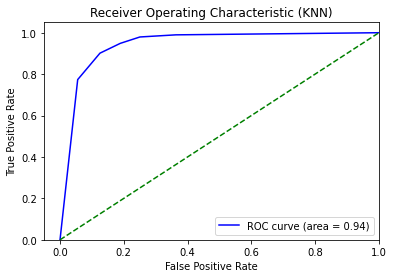

In [458]:
print("Classification report for knn: \n{}".format(classification_report(y_test,y_knn)))
print("Confusion matrix for knn: \n{}".format(confusion_matrix(y_test,y_knn)))
print("Accuracy score for knn: {:.2f}".format(accuracy_score(y_test,y_knn)))
# calculate precision, recall, and f1 scores
prec_knn = precision_score(y_test,y_knn)
rec_knn = recall_score(y_test,y_knn)
f1_knn = f1_score(y_test,y_knn)
print("Precision score for knn: {:.2f}".format(prec_knn))
print("Recall score for knn: {:.2f}".format(rec_knn))
print("F1 score for knn: {:.2f}".format(f1_knn))
sens_svm,spec_svm = calc_sens_spec(y_test,y_knn)
fpr, tpr, _ = roc_curve(y_test,  y_knn_prob[:,1])
auc_knn = roc_auc_score(y_test, y_knn_prob[:,1])
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_knn)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (KNN)')
ax.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, 'Confusion Matrix KNN')

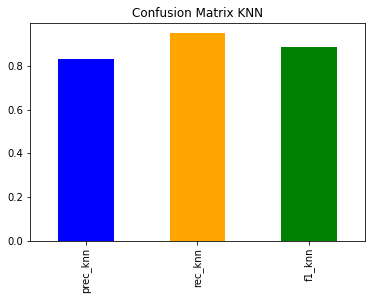

In [459]:
bar_knn = pd.DataFrame({"KNN": [prec_knn, rec_knn, f1_knn]},index=["prec_knn", "rec_knn", "f1_knn"])
bar_knn['KNN'].plot(kind="bar", color=['blue', 'orange', 'green'])
plt.title("Confusion Matrix KNN")

In [460]:
svm_model = SVC(kernel='rbf',probability=True)
svm_model.fit(X_train_std, y_train)
# Predicting the test set results
y_svm = svm_model.predict(X_test_std)
y_svm_prob = svm_model.predict_proba(X_test_std)

Classification report for SVM: 
              precision    recall  f1-score   support

           0       0.90      0.83      0.86       487
           1       0.84      0.91      0.87       486

    accuracy                           0.87       973
   macro avg       0.87      0.87      0.87       973
weighted avg       0.87      0.87      0.87       973

Confusion matrix for SVM: 
[[405  82]
 [ 46 440]]
Accuracy score for SVM: 0.87
Precision score for SVM: 0.84
Recall score for SVM: 0.91
F1 score for SVM: 0.87


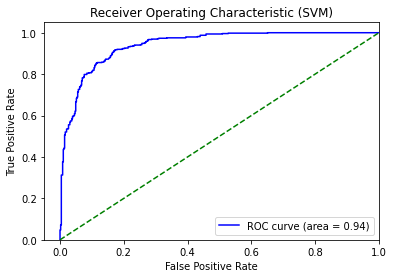

In [461]:
print("Classification report for SVM: \n{}".format(classification_report(y_test,y_svm)))
print("Confusion matrix for SVM: \n{}".format(confusion_matrix(y_test,y_svm)))
print("Accuracy score for SVM: {:.2f}".format(accuracy_score(y_test,y_svm)))
# calculate precision, recall, and f1 scores
prec_svm = precision_score(y_test,y_svm)
rec_svm = recall_score(y_test,y_svm)
f1_svm = f1_score(y_test,y_svm)
print("Precision score for SVM: {:.2f}".format(prec_svm))
print("Recall score for SVM: {:.2f}".format(rec_svm))
print("F1 score for SVM: {:.2f}".format(f1_svm))
sens_svm,spec_svm = calc_sens_spec(y_test,y_svm)
fpr, tpr, _ = roc_curve(y_test,  y_svm_prob[:,1])
auc_svm = roc_auc_score(y_test, y_svm_prob[:,1])
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_svm)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (SVM)')
ax.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, 'Confusion Matrix SVM')

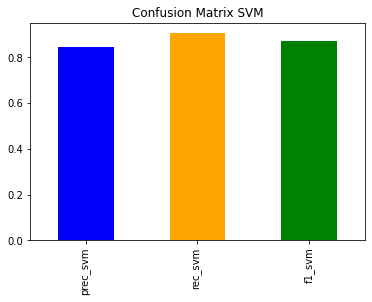

In [462]:
bar_svm = pd.DataFrame({"SVM": [prec_svm, rec_svm, f1_svm]},index=["prec_svm", "rec_svm", "f1_svm"])
bar_svm['SVM'].plot(kind="bar", color=['blue', 'orange', 'green'])
plt.title("Confusion Matrix SVM")

In [463]:
gnb_model = GaussianNB()
gnb_model.fit(X_train_std, y_train)
# Predicting the test set results
y_gnb = gnb_model.predict(X_test_std)
y_gnb_prob = gnb_model.predict_proba(X_test_std)

Classification report for GNB: 
              precision    recall  f1-score   support

           0       0.85      0.74      0.79       487
           1       0.77      0.87      0.82       486

    accuracy                           0.81       973
   macro avg       0.81      0.81      0.81       973
weighted avg       0.81      0.81      0.81       973

Confusion matrix for GNB: 
[[361 126]
 [ 62 424]]
Accuracy score for GNB: 0.81
Precision score for GNB: 0.77
Recall score for GNB: 0.87
F1 score for GNB: 0.82


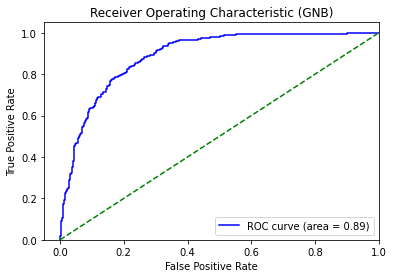

In [464]:
print("Classification report for GNB: \n{}".format(classification_report(y_test,y_gnb)))
print("Confusion matrix for GNB: \n{}".format(confusion_matrix(y_test,y_gnb)))
print("Accuracy score for GNB: {:.2f}".format(accuracy_score(y_test,y_gnb)))
# calculate precision, recall, and f1 scores
prec_gnb = precision_score(y_test,y_gnb)
rec_gnb = recall_score(y_test,y_gnb)
f1_gnb = f1_score(y_test,y_gnb)
print("Precision score for GNB: {:.2f}".format(prec_gnb))
print("Recall score for GNB: {:.2f}".format(rec_gnb))
print("F1 score for GNB: {:.2f}".format(f1_gnb))
sens_gnb,spec_gnb = calc_sens_spec(y_test,y_gnb)
fpr, tpr, _ = roc_curve(y_test,  y_gnb_prob[:,1])
auc_gnb = roc_auc_score(y_test, y_gnb_prob[:,1])
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_gnb)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (GNB)')
ax.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, 'Confusion Matrix GNB')

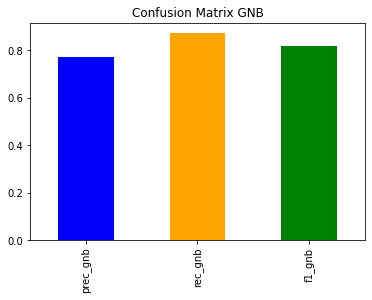

In [465]:
bar_gnb = pd.DataFrame({"GNB": [prec_gnb, rec_gnb, f1_gnb]},index=["prec_gnb", "rec_gnb", "f1_gnb"])
bar_gnb['GNB'].plot(kind="bar", color=['blue', 'orange', 'green'])
plt.title("Confusion Matrix GNB")

In [466]:
logit_model = LogisticRegression(solver='lbfgs', random_state=42)
logit_model.fit(X_train_std, y_train)
# Predicting the test set results
y_logit = logit_model.predict(X_test_std)
y_logit_prob = logit_model.predict_proba(X_test_std)

Classification report for LR: 
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       487
           1       0.80      0.84      0.82       486

    accuracy                           0.82       973
   macro avg       0.82      0.82      0.82       973
weighted avg       0.82      0.82      0.82       973

Confusion matrix for LR: 
[[388  99]
 [ 78 408]]
Accuracy score for LR: 0.82
Precision score for LR: 0.80
Recall score for LR: 0.84
F1 score for LR: 0.82


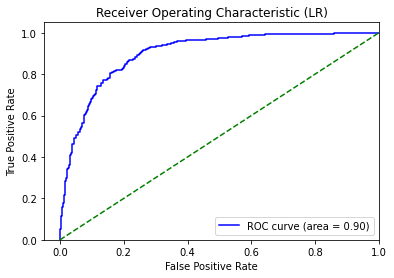

In [467]:
print("Classification report for LR: \n{}".format(classification_report(y_test,y_logit)))
print("Confusion matrix for LR: \n{}".format(confusion_matrix(y_test,y_logit)))
print("Accuracy score for LR: {:.2f}".format(accuracy_score(y_test,y_logit)))
# calculate precision, recall, and f1 scores
prec_logit = precision_score(y_test,y_logit)
rec_logit = recall_score(y_test,y_logit)
f1_logit = f1_score(y_test,y_logit)
print("Precision score for LR: {:.2f}".format(prec_logit))
print("Recall score for LR: {:.2f}".format(rec_logit))
print("F1 score for LR: {:.2f}".format(f1_logit))
sens_logit,spec_logit = calc_sens_spec(y_test,y_logit)
fpr, tpr, _ = roc_curve(y_test,  y_logit_prob[:,1])
auc_logit = roc_auc_score(y_test, y_logit_prob[:,1])
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_logit)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (LR)')
ax.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, 'Confusion Matrix LR')

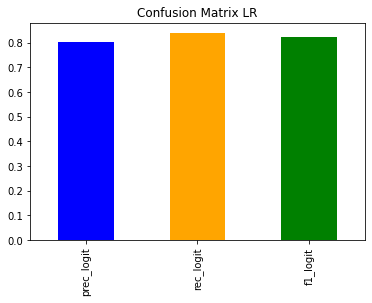

In [468]:
bar_logit = pd.DataFrame({"LR": [prec_logit, rec_logit, f1_logit]},index=["prec_logit", "rec_logit", "f1_logit"])
bar_logit['LR'].plot(kind="bar", color=['blue', 'orange', 'green'])
plt.title("Confusion Matrix LR")

In [469]:
dtree_model = DecisionTreeClassifier(random_state=42)
dtree_model.fit(X_train_std, y_train)
# Predicting the test set results
y_dtree = dtree_model.predict(X_test_std)
y_dtree_prob = dtree_model.predict_proba(X_test_std)

Classification report for DT: 
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       487
           1       0.92      0.93      0.93       486

    accuracy                           0.92       973
   macro avg       0.92      0.92      0.92       973
weighted avg       0.92      0.92      0.92       973

Confusion matrix for DT: 
[[449  38]
 [ 35 451]]
Accuracy score for DT: 0.92
Precision score for DT: 0.92
Recall score for DT: 0.93
F1 score for DT: 0.93


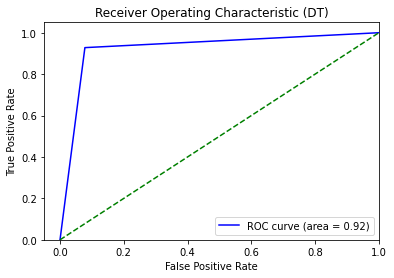

In [470]:
print("Classification report for DT: \n{}".format(classification_report(y_test,y_dtree)))
print("Confusion matrix for DT: \n{}".format(confusion_matrix(y_test,y_dtree)))
print("Accuracy score for DT: {:.2f}".format(accuracy_score(y_test,y_dtree)))
# calculate precision, recall, and f1 scores
prec_dtree = precision_score(y_test,y_dtree)
rec_dtree = recall_score(y_test,y_dtree)
f1_dtree = f1_score(y_test,y_dtree)
print("Precision score for DT: {:.2f}".format(prec_dtree))
print("Recall score for DT: {:.2f}".format(rec_dtree))
print("F1 score for DT: {:.2f}".format(f1_dtree))
sens_dtree,spec_dtree = calc_sens_spec(y_test,y_dtree)
fpr, tpr, _ = roc_curve(y_test,  y_dtree_prob[:,1])
auc_dtree = roc_auc_score(y_test, y_dtree_prob[:,1])
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_dtree)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (DT)')
ax.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, 'Confusion Matrix DT')

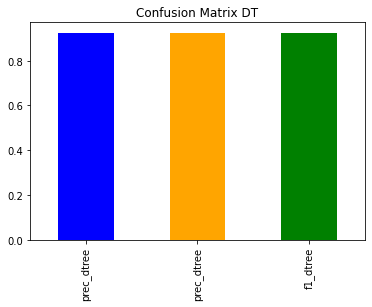

In [471]:
bar_DT = pd.DataFrame({"DT": [prec_dtree, prec_dtree, f1_dtree]},index=["prec_dtree", "prec_dtree", "f1_dtree"])
bar_DT['DT'].plot(kind="bar", color=['blue', 'orange', 'green'])
plt.title("Confusion Matrix DT")

In [472]:
ranfor_model = RandomForestClassifier(n_estimators=100, random_state=42)
ranfor_model.fit(X_train_std, y_train)
# Predicting the test set results
y_ranfor = ranfor_model.predict(X_test_std)
y_ranfor_prob = ranfor_model.predict_proba(X_test_std)

Classification report for RF: 
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       487
           1       0.94      0.96      0.95       486

    accuracy                           0.95       973
   macro avg       0.95      0.95      0.95       973
weighted avg       0.95      0.95      0.95       973

Confusion matrix for RF: 
[[459  28]
 [ 18 468]]
Accuracy score for RF: 0.95
Precision score for RF: 0.94
Recall score for RF: 0.96
F1 score for RF: 0.95


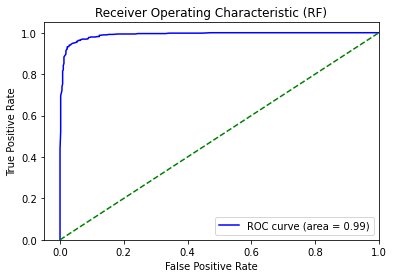

In [473]:
print("Classification report for RF: \n{}".format(classification_report(y_test,y_ranfor)))
print("Confusion matrix for RF: \n{}".format(confusion_matrix(y_test,y_ranfor)))
print("Accuracy score for RF: {:.2f}".format(accuracy_score(y_test,y_ranfor)))
# calculate precision, recall, and f1 scores
prec_ranfor = precision_score(y_test,y_ranfor)
rec_ranfor = recall_score(y_test,y_ranfor)
f1_ranfor = f1_score(y_test,y_ranfor)
print("Precision score for RF: {:.2f}".format(prec_ranfor))
print("Recall score for RF: {:.2f}".format(rec_ranfor))
print("F1 score for RF: {:.2f}".format(f1_ranfor))
sens_ranfor,spec_ranfor = calc_sens_spec(y_test,y_ranfor)
fpr, tpr, _ = roc_curve(y_test,  y_ranfor_prob[:,1])
auc_ranfor = roc_auc_score(y_test, y_ranfor_prob[:,1])
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_ranfor)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (RF)')
ax.legend(loc="lower right")
plt.show()


Text(0.5, 1.0, 'Confusion Matrix RF')

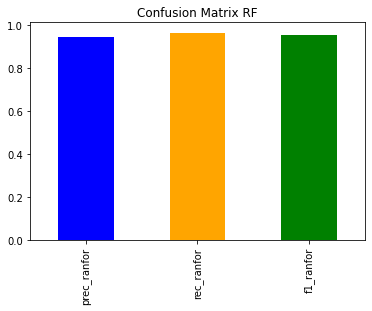

In [474]:
bar_RF = pd.DataFrame({"RF": [prec_ranfor, rec_ranfor, f1_ranfor]},index=["prec_ranfor", "rec_ranfor", "f1_ranfor"])
bar_RF['RF'].plot(kind="bar", color=['blue', 'orange', 'green'])
plt.title("Confusion Matrix RF")

In [475]:
lgbm_model = LGBMClassifier(n_estimators=100, random_state=42)
lgbm_model.fit(X_train_std, y_train)
# Predicting the test set results
y_lgbm = lgbm_model.predict(X_test_std)
y_lgbm_prob = lgbm_model.predict_proba(X_test_std)

Classification report for LGBM: 
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       487
           1       0.92      0.95      0.94       486

    accuracy                           0.93       973
   macro avg       0.93      0.93      0.93       973
weighted avg       0.93      0.93      0.93       973

Confusion matrix for LGBM: 
[[448  39]
 [ 25 461]]
Accuracy score for LGBM: 0.93
Precision score for LGBM: 0.92
Recall score for LGBM: 0.95
F1 score for LGBM: 0.94


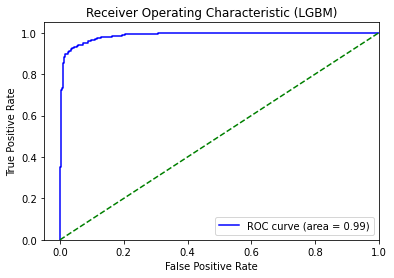

In [476]:
print("Classification report for LGBM: \n{}".format(classification_report(y_test,y_lgbm)))
print("Confusion matrix for LGBM: \n{}".format(confusion_matrix(y_test,y_lgbm)))
print("Accuracy score for LGBM: {:.2f}".format(accuracy_score(y_test,y_lgbm)))
# calculate precision, recall, and f1 scores
prec_lgbm = precision_score(y_test,y_lgbm)
rec_lgbm = recall_score(y_test,y_lgbm)
f1_lgbm = f1_score(y_test,y_lgbm)
print("Precision score for LGBM: {:.2f}".format(prec_lgbm))
print("Recall score for LGBM: {:.2f}".format(rec_lgbm))
print("F1 score for LGBM: {:.2f}".format(f1_lgbm))
sens_lgbm,spec_lgbm = calc_sens_spec(y_test,y_lgbm)
fpr, tpr, _ = roc_curve(y_test,  y_lgbm_prob[:,1])
auc_lgbm = roc_auc_score(y_test, y_lgbm_prob[:,1])
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_lgbm)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (LGBM)')
ax.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, 'Confusion Matrix LGBM')

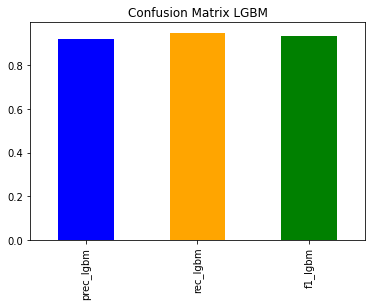

In [477]:
bar_LGBM = pd.DataFrame({"LGBM": [prec_lgbm, rec_lgbm, f1_lgbm]},index=["prec_lgbm", "rec_lgbm", "f1_lgbm"])
bar_LGBM['LGBM'].plot(kind="bar", color=['blue', 'orange', 'green'])
plt.title("Confusion Matrix LGBM")

In [478]:
xgb_model = XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train_std, y_train)
# Predicting the test set results
y_xgb = xgb_model.predict(X_test_std)
y_xgb_prob = xgb_model.predict_proba(X_test_std)

Classification report for XGB: 
              precision    recall  f1-score   support

           0       0.89      0.84      0.87       487
           1       0.85      0.90      0.87       486

    accuracy                           0.87       973
   macro avg       0.87      0.87      0.87       973
weighted avg       0.87      0.87      0.87       973

Confusion matrix for XGB: 
[[410  77]
 [ 50 436]]
Accuracy score for XGB: 0.87
Precision score for XGB: 0.85
Recall score for XGB: 0.90
F1 score for XGB: 0.87


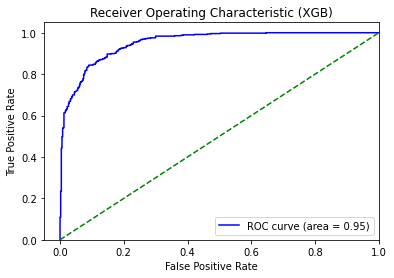

In [479]:
print("Classification report for XGB: \n{}".format(classification_report(y_test,y_xgb)))
print("Confusion matrix for XGB: \n{}".format(confusion_matrix(y_test,y_xgb)))
print("Accuracy score for XGB: {:.2f}".format(accuracy_score(y_test,y_xgb)))
# calculate precision, recall, and f1 scores
prec_xgb = precision_score(y_test,y_xgb)
rec_xgb = recall_score(y_test,y_xgb)
f1_xgb = f1_score(y_test,y_xgb)
print("Precision score for XGB: {:.2f}".format(prec_xgb))
print("Recall score for XGB: {:.2f}".format(rec_xgb))
print("F1 score for XGB: {:.2f}".format(f1_xgb))
sens_xgb,spec_xgb = calc_sens_spec(y_test,y_xgb)
fpr, tpr, _ = roc_curve(y_test,  y_xgb_prob[:,1])
auc_xgb = roc_auc_score(y_test, y_xgb_prob[:,1])
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_xgb)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (XGB)')
ax.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, 'Confusion Matrix XGB')

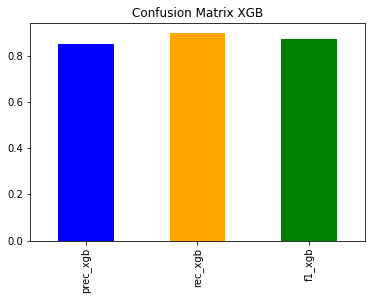

In [480]:
bar_XGB = pd.DataFrame({"XGB": [prec_xgb,rec_xgb,f1_xgb]},index=["prec_xgb", "rec_xgb", "f1_xgb"])
bar_XGB['XGB'].plot(kind="bar", color=['blue', 'orange', 'green'])
plt.title("Confusion Matrix XGB")

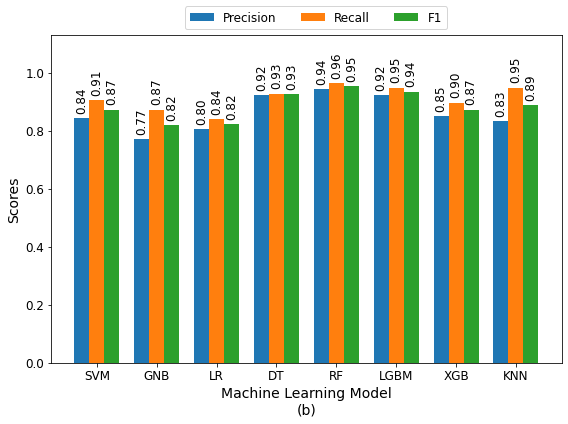

In [481]:
ml_names = ['SVM', 'GNB', 'LR', 'DT', 'RF', 'LGBM', 'XGB','KNN']

prec_all = [prec_svm, prec_gnb, prec_logit, prec_dtree, prec_ranfor, prec_lgbm, prec_xgb,prec_knn]
rec_all = [rec_svm, rec_gnb, rec_logit, rec_dtree, rec_ranfor, rec_lgbm, rec_xgb,rec_knn]
f1_all = [f1_svm, f1_gnb, f1_logit, f1_dtree, f1_ranfor, f1_lgbm, f1_xgb,f1_knn]

def autolabel(bars):
    """Attach a text label above each bar in displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # 3 points vertical offset
                    textcoords="offset points",
                    fontsize=12,
                    rotation=90,
                    ha='center', va='bottom')

width = 0.25  # the width of the bars
r1 = np.arange(len(ml_names))  # the label locations
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim([0,1.15])
ax.set_ylabel('Scores',fontsize=14)
#ax.set_title('Performance benchmark across ML models')
ax.set_xticks(r2)
ax.set_xticklabels(ml_names)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel("Machine Learning Model\n(a)",fontsize=14)
ax.legend(loc='lower left',ncol=3,bbox_to_anchor=(0.25,1),fontsize=12)
fig.tight_layout()
fig.savefig("ml_benchmark_auc.pdf", bbox_inches='tight')
plt.show()

# plot sensitivity, specificity, and auc
fig, ax = plt.subplots(figsize=(8,6))
bar1 = ax.bar(r1, prec_all, width, label='Precision')
bar2 = ax.bar(r2, rec_all, width, label='Recall')
bar3 = ax.bar(r3, f1_all, width, label='F1')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim([0,1.13])
ax.set_ylabel('Scores',fontsize=14)
#ax.set_title('Performance benchmark across ML models')
ax.set_xticks(r2)
ax.set_xticklabels(ml_names)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel("Machine Learning Model\n(b)",fontsize=14)
ax.legend(loc='lower left',ncol=3,bbox_to_anchor=(0.25,1),fontsize=12)
autolabel(bar1)
autolabel(bar2)
autolabel(bar3)
fig.tight_layout()
fig.savefig("ml_benchmark_f1.pdf", bbox_inches='tight')
plt.show()

